[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedsalim3/iaifi-hackathon-2025/blob/main/notebooks/dataset-exploration.ipynb)

If you are on colab, you may need to download the datasets, refer to [data access](https://ahmedsalim3.github.io/iaifi-hackathon-2025/datasets/#data-access) to know how to get them ready.

## Dataset Exploration & Analysis

This Jupyter Notebook provides a comprehensive exploration of the `nebula.data` package. It demonstrates how to load, inspect, and analyze two key datasets: a simulated **Source Dataset** from IllustrisTNG and a real-world **Target Dataset** from Galaxy Zoo 2. The notebook also includes visualizations of class distributions and the computation of class weights for machine learning applications

In [1]:
import json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms

from nebula.data import SourceDataset, TargetDataset
from nebula.data.class_weights import compute_dataset_mean_std, compute_class_weights

In [ ]:
# --- Define paths ---
DATA_ROOT = "../data"
SRC_JSON = Path(DATA_ROOT) / "source" / "labels_master.json"
TGT_JSON = Path(DATA_ROOT) / "target" / "labels_master_top_n.json"

In [3]:
# --- Inspect raw JSON entries ---
with open(SRC_JSON, "r") as f:
    src_data = json.load(f)

with open(TGT_JSON, "r") as f:
    tgt_data = json.load(f)

print("Source dataset sample:\n", json.dumps(src_data[0], indent=2))
print("\nTarget dataset sample:\n", json.dumps(tgt_data[0], indent=2))


Source dataset sample:
 {
  "image_path": "llustrisTNG/subhalo_0.png",
  "subhalo_id": 0,
  "mass": 3682930000000.0,
  "star_forming": false,
  "has_agn": false,
  "is_compact": true,
  "metallicity": 0.03570494,
  "classification": "elliptical",
  "is_metalrich": true
}

Target dataset sample:
 {
  "image_path": "data/target/images_gz2/images/76446.jpg",
  "objid": 587734948058431657,
  "classification": "elliptical",
  "metrics": {
    "artifact_prob": 0.0,
    "smooth_prob": 1.0,
    "features_prob": 0.0,
    "edgeon_prob": 0.0,
    "spiral_prob": 0.0,
    "nospiral_prob": 1.0,
    "irregular_prob": 0.0,
    "merger_prob": 0.0,
    "disturbed_prob": 0.0,
    "odd_prob": 0.0841383614728033
  }
}


In [4]:
# --- Load datasets ---
train_transform = transforms.Compose([
    transforms.Resize((128,128)), # image size
    transforms.ToTensor(),
])

src_train = SourceDataset(DATA_ROOT, transform=train_transform, split="train")
tgt_train = TargetDataset(DATA_ROOT, transform=train_transform, split="train")

print(src_train.summary)
print(tgt_train.summary)

SourceDataset
split: train
root: ../data/source
# images: 1240
# classes: 3
image dims: 448x448
transform: Yes
class distribution: elliptical: 269 (21.7%), spiral: 853 (68.8%), irregular: 118 (9.5%)

TargetDataset
split: train
root: ../data/target
# images: 2995
# classes: 3
image dims: 424x424
transform: Yes
class distribution: elliptical: 730 (24.4%), spiral: 1587 (53.0%), irregular: 678 (22.6%)



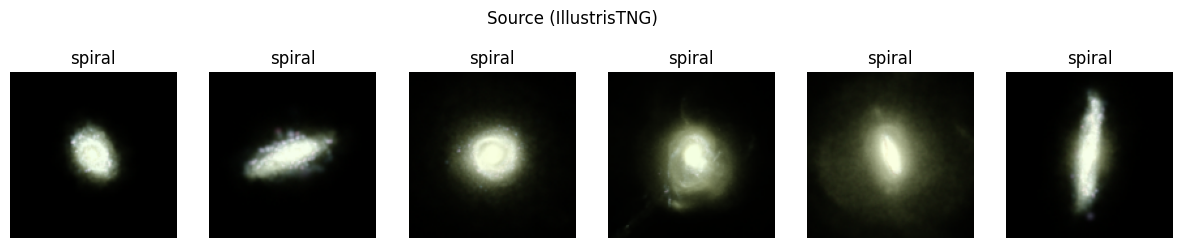

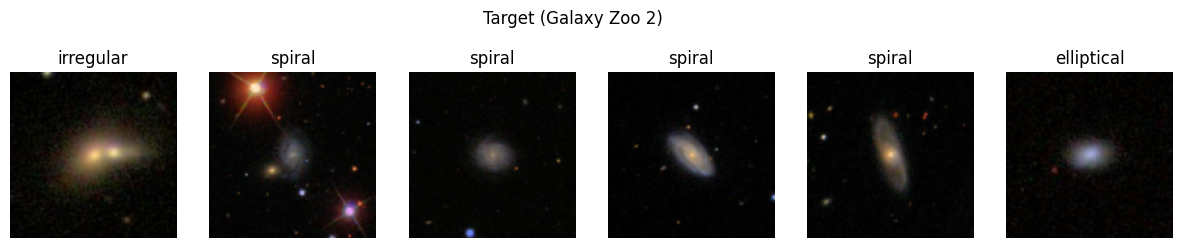

In [5]:
# --- Visualize some dataset samples ---
def show_samples(dataset, n=6, title="Samples"):
    _, axs = plt.subplots(1, n, figsize=(15,3))
    for i in range(n):
        img_tensor, label = dataset[random.randint(0, len(dataset)-1)]
        img_pil = transforms.ToPILImage()(img_tensor)
        axs[i].imshow(img_pil)
        axs[i].set_title(dataset.idx2label[label.item()])
        axs[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(src_train, title="Source (IllustrisTNG)")
show_samples(tgt_train, title="Target (Galaxy Zoo 2)")

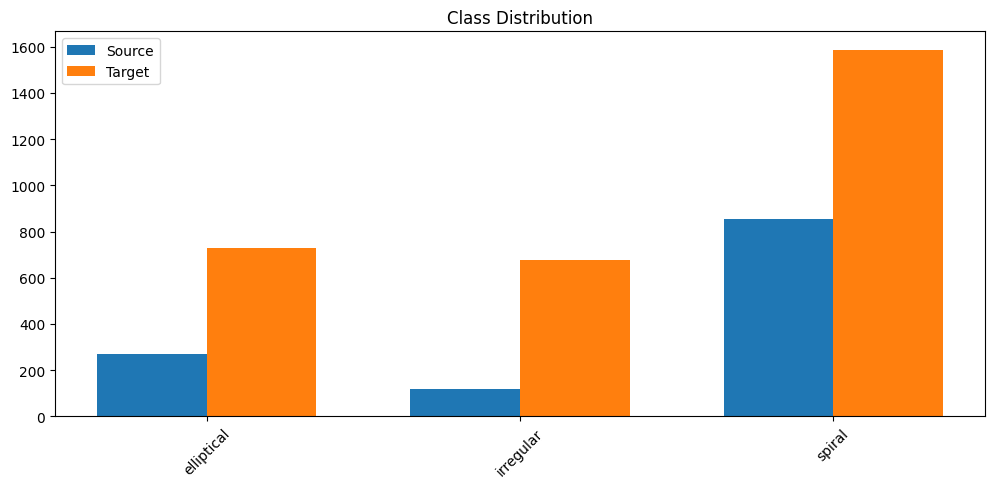

In [6]:
# --- Class distributions ---
src_dist = {k: v["count"] for k,v in src_train.get_class_distribution().items()}
tgt_dist = {k: v["count"] for k,v in tgt_train.get_class_distribution().items()}

labels = sorted(list(src_dist.keys()))
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, [src_dist[l] for l in labels], width, label="Source")
plt.bar(x + width/2, [tgt_dist[l] for l in labels], width, label="Target")

plt.xticks(x, labels, rotation=45)
plt.title("Class Distribution")
plt.legend()
plt.show()

In machine learning, class weights are often used to address dataset imbalance. We'll compute both "effective" and "balanced" class weights for both the source and target datasets and visualize them alongside their respective class distributions.

This technique ensures:

- Minority classes are assigned higher weights
- Majority classes get lower weights

These weights can be passed to the loss function so the model pays more attention to underrepresented classes. This way, incorrect predictions on rare classes are penalized more, helping the model not just favor the "popular" ones.

Source class weights: tensor([1.5366, 0.4846, 3.5028])
Target class weights: tensor([1.3676, 0.6291, 1.4725])


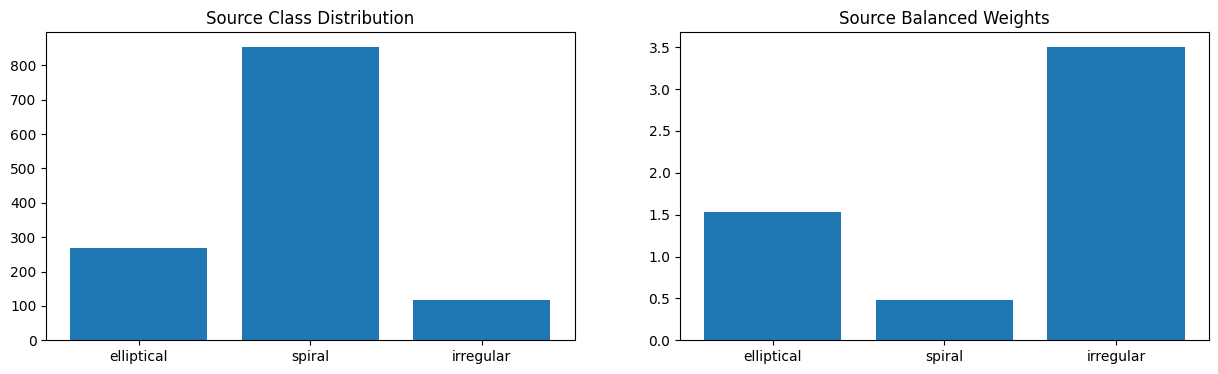

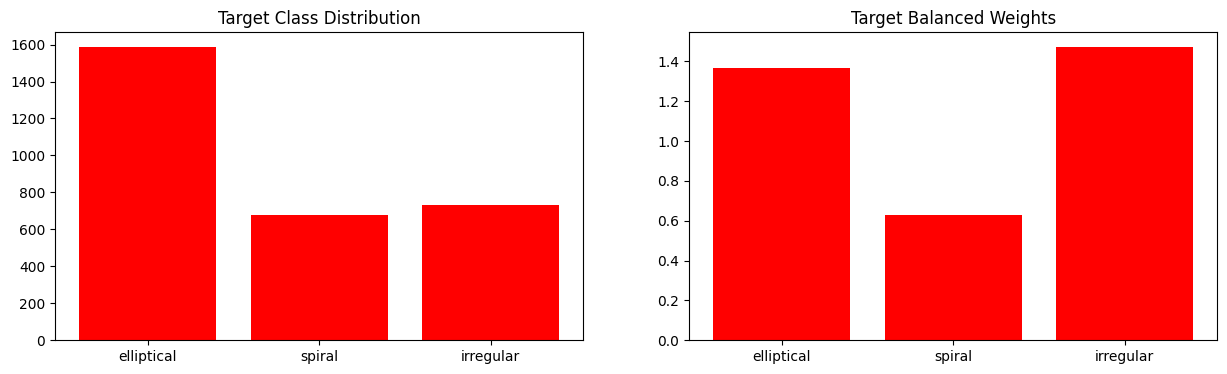

In [7]:
labels_src = [sample['label'] for sample in src_train.samples]
labels_tgt = [sample['label'] for sample in tgt_train.samples]

all_classes = sorted(set(labels_src + labels_tgt))
labels = [src_train.idx2label[c] for c in all_classes]

# compute weights
class_weights_src = compute_class_weights(labels_src, method="balanced")
class_weights_tgt = compute_class_weights(labels_tgt, method="balanced")


print("Source class weights:", class_weights_src)
print("Target class weights:", class_weights_tgt)

# --- Plotting the distributions ---
src_dist = {k: v["count"] for k,v in src_train.get_class_distribution().items()}
tgt_dist = {k: v["count"] for k,v in tgt_train.get_class_distribution().items()}

# source dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(src_dist)), list(src_dist.values()))
ax1.set_title("Source Class Distribution")
ax1.set_xticks(range(len(labels)), labels)
ax2.bar(range(len(class_weights_src)), class_weights_src.numpy())
ax2.set_title("Source Balanced Weights")
ax2.set_xticks(range(len(labels)), labels)
plt.show()

# target dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(tgt_dist)), list(tgt_dist.values()), color="red")
ax1.set_title("Target Class Distribution")
ax1.set_xticks(range(len(labels)), labels)
ax2.bar(range(len(class_weights_tgt)), class_weights_tgt.numpy(), color="red")
ax2.set_title("Target Balanced Weights")
ax2.set_xticks(range(len(labels)), labels)
plt.show()


The effective method uses the **"effective number of samples"** method with β=0.9999. This adjusts weights based on how many examples each class has, so the model doesn't get biased toward the majority class. The method comes from the paper [_Class-Balanced Loss Based on Effective Number of Samples_](https://arxiv.org/pdf/1901.05555), and its official [implementation in PyTorch](https://github.com/vandit15/Class-balanced-loss-pytorch/blob/master/class_balanced_loss.py#L53-L91)

Source class weights: tensor([0.8363, 0.2715, 1.8922])
Target class weights: tensor([1.1748, 0.5636, 1.2616])


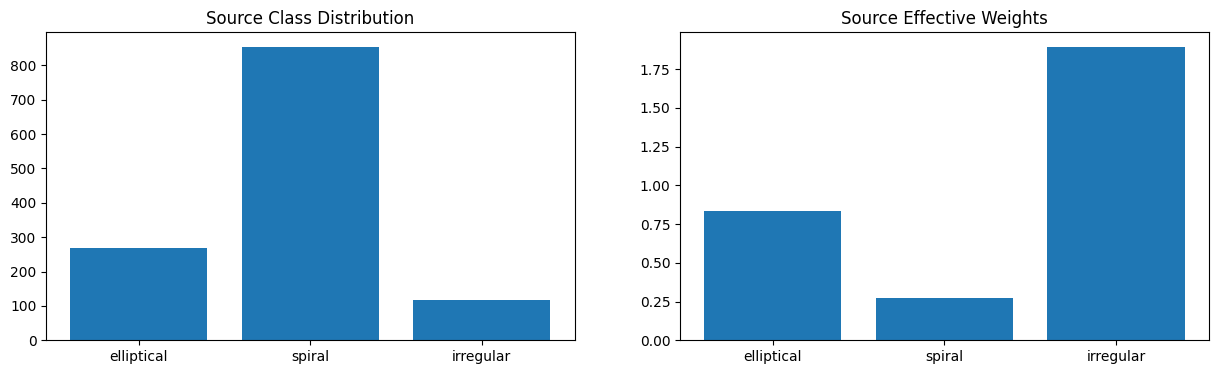

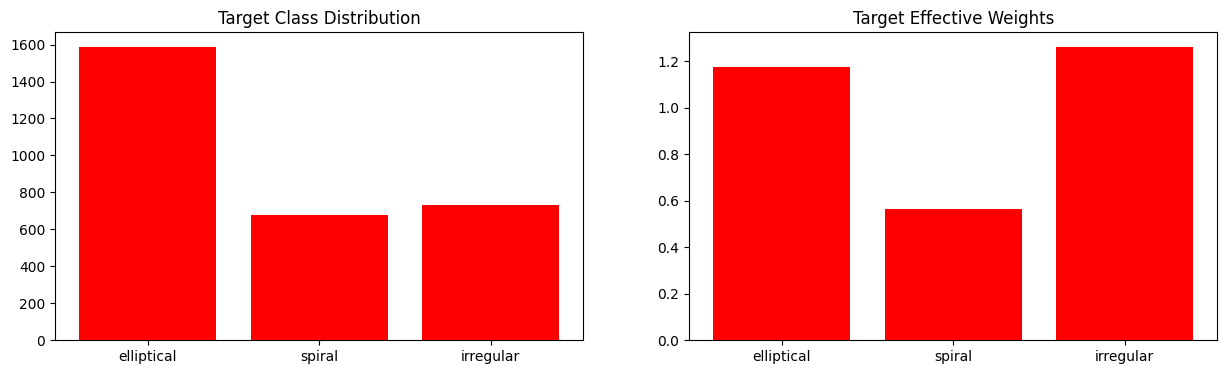

In [8]:
# compute weights
class_weights_src = compute_class_weights(labels_src, method="effective")
class_weights_tgt = compute_class_weights(labels_tgt, method="effective")


print("Source class weights:", class_weights_src)
print("Target class weights:", class_weights_tgt)

# --- Plotting the distributions ---
src_dist = {k: v["count"] for k,v in src_train.get_class_distribution().items()}
tgt_dist = {k: v["count"] for k,v in tgt_train.get_class_distribution().items()}

# source dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(src_dist)), list(src_dist.values()))
ax1.set_title("Source Class Distribution")
ax1.set_xticks(range(len(labels)), labels)
ax2.bar(range(len(class_weights_src)), class_weights_src.numpy())
ax2.set_title("Source Effective Weights")
ax2.set_xticks(range(len(labels)), labels)
plt.show()

# target dataset
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(range(len(tgt_dist)), list(tgt_dist.values()), color="red")
ax1.set_title("Target Class Distribution")
ax1.set_xticks(range(len(labels)), labels)
ax2.bar(range(len(class_weights_tgt)), class_weights_tgt.numpy(), color="red")
ax2.set_title("Target Effective Weights")
ax2.set_xticks(range(len(labels)), labels)
plt.show()

In [9]:
# --- Compute normalization statistics (mean/std) ---

# inorder to compute the mean/std, the images are not transformed
src_train = SourceDataset(DATA_ROOT, split="train")
tgt_train = TargetDataset(DATA_ROOT, split="train")

mean, std = compute_dataset_mean_std(src_train)
print("Source mean:", mean.tolist())
print("Source std:", std.tolist())

mean, std = compute_dataset_mean_std(tgt_train)
print("Target mean:", mean.tolist())
print("Target std:", std.tolist())


Computing mean/std: 100%|██████████| 1240/1240 [00:06<00:00, 177.47it/s]


Source mean: [0.10835663229227066, 0.11768525838851929, 0.09033632278442383]
Source std: [0.20970022678375244, 0.2209458202123642, 0.19074109196662903]


Computing mean/std: 100%|██████████| 2995/2995 [00:07<00:00, 421.19it/s]

Target mean: [0.04580982029438019, 0.0412026010453701, 0.03277532011270523]
Target std: [0.09006255865097046, 0.0773979052901268, 0.07352857291698456]
